**Air Quality of Altamura - Final Project - Machine Learning for Data Science**

**STUDENT:** Chiara Zandomeneghi - VR513170


2016 - 2020

https://www.arpa.puglia.it/pagina3139_dati-storici-qualit-delllaria.html

DateTime
NO
NO2
NOX
O3
PM10
PM2.5
AQ

# explain characteristics of dataset

In [1]:
#import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import skew
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
#LOAD DATASET
#load the dataset from CSV file
aq_df = pd.read_csv('_Altamura_2016_2020_with_aq.csv')
aq_df

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
0,2016-01-01 01:00:00.000,10.446555,25.236488,41.255988,38.497517,NaN,NaN,NaN
1,2016-01-01 02:00:00.000,11.190016,29.566211,46.724116,36.357080,44.688599,NaN,41.378332
2,2016-01-01 03:00:00.000,10.596083,22.026813,38.278240,42.561329,NaN,NaN,NaN
3,2016-01-01 04:00:00.000,7.879057,14.952126,27.037399,46.502254,81.074501,NaN,63.905561
4,2016-01-01 05:00:00.000,7.716848,17.829514,29.663722,45.634229,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
60661,2020-12-31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.600000,16.4,60.042918
60662,2020-12-31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918
60663,2020-12-31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918
60664,2021-01-01 00:00:00,2.495988,22.675000,26.596570,38.168679,19.600000,16.4,60.042918


In [3]:
# Replace in the datetime column (change 'datetime_column' to your actual column name)
datetime_col = 'DateTime'

aq_df[datetime_col] = aq_df[datetime_col].str.replace('-', '/', regex=False)

# Optional: remove milliseconds (.000 .sss etc)
aq_df[datetime_col] = aq_df[datetime_col].str.replace(r'\.\d{1,3}$', '', regex=True)

# Optional: remove any trailing .000000 or similar
aq_df[datetime_col] = aq_df[datetime_col].str.replace(r'\.0+$', '', regex=True)

# Save back
aq_df.to_csv("AM_AQ_20162020.csv", index=False)

aq_df[datetime_col] = pd.to_datetime(aq_df[datetime_col], errors='coerce')
# Then format exactly as you want when saving/displaying:
aq_df[datetime_col] = aq_df[datetime_col].dt.strftime('%Y/%m/%d %H:%M:%S')

In [4]:
#show dataframe info
aq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60666 entries, 0 to 60665
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  60666 non-null  object 
 1   NO        56116 non-null  float64
 2   NO2       56115 non-null  float64
 3   NOX       56142 non-null  float64
 4   O3        55133 non-null  float64
 5   PM10      53125 non-null  float64
 6   PM2.5     50298 non-null  float64
 7   AQ        53498 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.7+ MB


In [5]:
aq_df.describe()

,NO,NO2,NOX,O3,PM10,PM2.5,AQ
count,56116.000000,56115.000000,56142.000000,55133.000000,53125.000000,50298.000000,53498.000000
mean,8.670329,23.966585,37.186254,66.353094,19.413909,11.896723,44.199293
std,12.134956,17.192600,33.043246,26.352670,9.390767,5.225941,16.691896
min,0.000000,0.009734,0.162730,0.000000,0.000000,3.100000,0.000000
25%,2.372480,11.331109,16.096521,49.049589,13.400000,7.900000,31.250000
50%,5.337750,20.124756,28.945595,66.495606,17.600000,10.900000,43.750000
75%,10.734157,32.209026,47.716497,83.500526,23.400000,14.800000,56.257512
max,411.701412,178.542330,796.962688,170.492181,323.565002,35.000000,184.936213


In [6]:
aq_df.head(10)

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
0,2016/01/01 01:00:00,10.446555,25.236488,41.255988,38.497517,NaN,NaN,NaN
1,2016/01/01 02:00:00,11.190016,29.566211,46.724116,36.357080,44.688599,NaN,41.378332
2,2016/01/01 03:00:00,10.596083,22.026813,38.278240,42.561329,NaN,NaN,NaN
3,2016/01/01 04:00:00,7.879057,14.952126,27.037399,46.502254,81.074501,NaN,63.905561
4,2016/01/01 05:00:00,7.716848,17.829514,29.663722,45.634229,NaN,NaN,NaN
5,2016/01/01 06:00:00,5.839177,9.545851,18.503284,53.661112,52.258900,NaN,48.387870
6,2016/01/01 07:00:00,5.733145,8.630194,17.425509,53.239767,NaN,NaN,NaN
7,2016/01/01 08:00:00,13.371830,18.135166,38.650507,46.216768,40.048801,NaN,37.082223
8,2016/01/01 09:00:00,5.823116,7.689242,16.623329,59.337483,NaN,NaN,NaN
9,2016/01/01 10:00:00,4.620896,5.567878,12.657822,67.102423,24.908400,NaN,23.063333


In [7]:
aq_df.tail(10)

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
60656,2020/12/31 20:00:00,10.434137,41.507723,57.679207,25.414405,19.6,16.4,60.042918
60657,2020/12/31 20:00:00,10.434137,41.507723,57.679207,25.414405,19.6,16.4,60.042918
60658,2020/12/31 21:00:00,8.277063,46.720254,59.606082,19.897200,19.6,16.4,60.042918
60659,2020/12/31 21:00:00,8.277063,46.720254,59.606082,19.897200,19.6,16.4,60.042918
60660,2020/12/31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.6,16.4,60.042918
60661,2020/12/31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.6,16.4,60.042918
60662,2020/12/31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.6,16.4,60.042918
60663,2020/12/31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.6,16.4,60.042918
60664,2021/01/01 00:00:00,2.495988,22.675000,26.596570,38.168679,19.6,16.4,60.042918
60665,2021/01/01 00:00:00,2.495988,22.675000,26.596570,38.168679,19.6,16.4,60.042918


In [8]:
#DATA CLEANING
pollutants = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']

aq_df.bfill(inplace=True)
aq_df

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
0,2016/01/01 01:00:00,10.446555,25.236488,41.255988,38.497517,44.688599,9.4,41.378332
1,2016/01/01 02:00:00,11.190016,29.566211,46.724116,36.357080,44.688599,9.4,41.378332
2,2016/01/01 03:00:00,10.596083,22.026813,38.278240,42.561329,81.074501,9.4,63.905561
3,2016/01/01 04:00:00,7.879057,14.952126,27.037399,46.502254,81.074501,9.4,63.905561
4,2016/01/01 05:00:00,7.716848,17.829514,29.663722,45.634229,52.258900,9.4,48.387870
...,...,...,...,...,...,...,...,...
60661,2020/12/31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.600000,16.4,60.042918
60662,2020/12/31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918
60663,2020/12/31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918
60664,2021/01/01 00:00:00,2.495988,22.675000,26.596570,38.168679,19.600000,16.4,60.042918


In [9]:
aq_df.isna().sum()

,0
DateTime,0
NO,0
NO2,0
NOX,0
O3,0
PM10,0
PM2.5,0
AQ,0


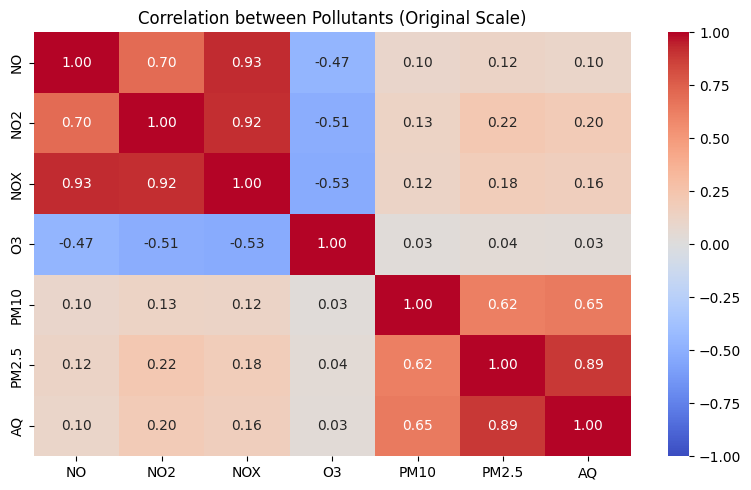

In [10]:
# Calculate correlation matrix - Traditional
aq_correlation_matrix = aq_df[['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']].corr()

# Visualize correlation matrix with .4f formatting
plt.figure(figsize=(8, 5))
sns.heatmap(aq_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between Pollutants (Original Scale)')
plt.tight_layout()
plt.show()

In [11]:
!pip install dcor

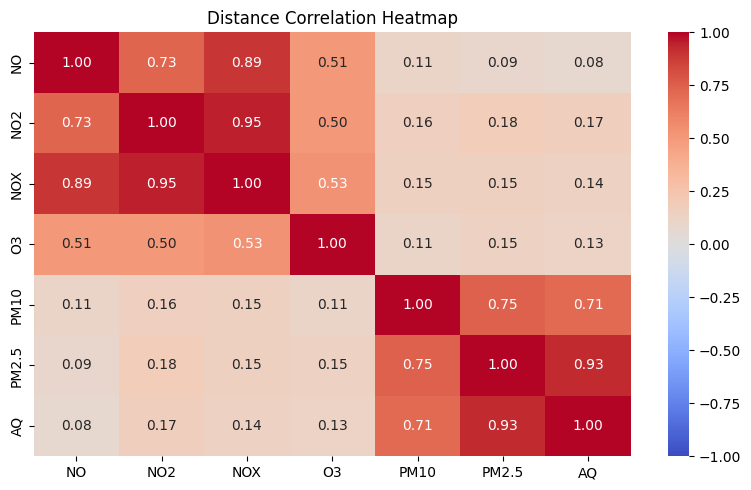

In [12]:
# Distance Correlation (dCor) — Best for general non-linear
import dcor

pollutants = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']

n = len(pollutants)
dist_corr_matrix = np.zeros((n, n))

# Compute distance correlation matrix
for i in range(n):
    for j in range(n):
        x = aq_df[pollutants[i]].values
        y = aq_df[pollutants[j]].values
        dist_corr_matrix[i, j] = dcor.distance_correlation(x, y)

# Plot heatmap with values
plt.figure(figsize=(8, 5))
sns.heatmap(dist_corr_matrix, annot=True, xticklabels=pollutants, yticklabels=pollutants, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Distance Correlation Heatmap")
plt.tight_layout()
plt.show()

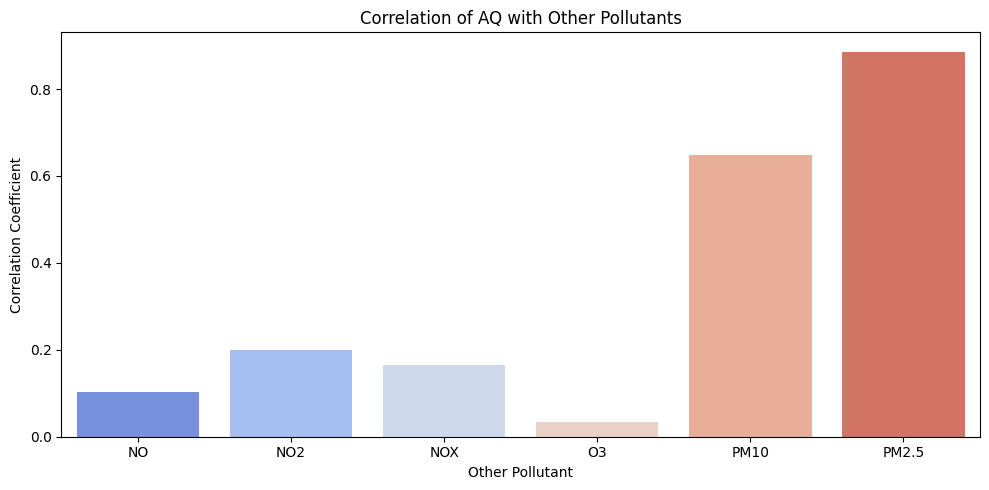

             AQ
NO     0.102983
NO2    0.199286
NOX    0.164128
O3     0.033999
PM10   0.647102
PM2.5  0.886169


In [13]:
# Visualize correlations for a specific pollutant (AQ)
pollutant = 'AQ'
AQ_corrs = aq_correlation_matrix[[pollutant]].drop(pollutant)
plt.figure(figsize=(10, 5))
sns.barplot(x=AQ_corrs.index, y=AQ_corrs[pollutant], hue=AQ_corrs.index, palette='coolwarm', legend=False)

plt.title(f'Correlation of {pollutant} with Other Pollutants')
plt.xlabel('Other Pollutant')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()
print(AQ_corrs)

Number of invalid dates: 0


<Figure size 1200x800 with 0 Axes>

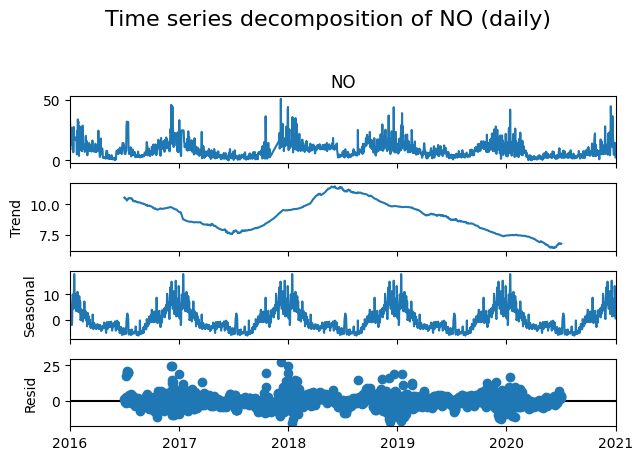

<Figure size 1200x800 with 0 Axes>

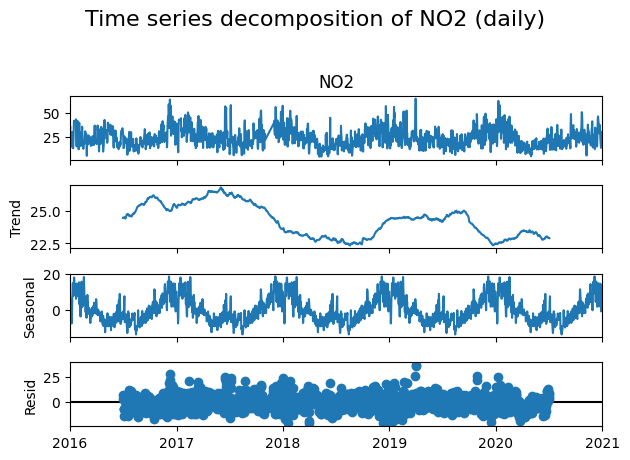

<Figure size 1200x800 with 0 Axes>

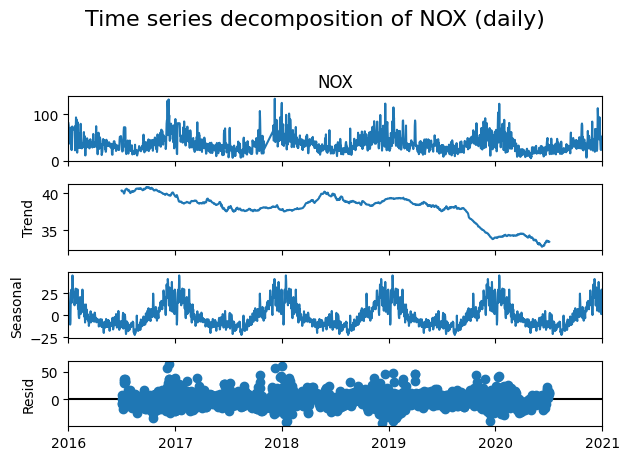

<Figure size 1200x800 with 0 Axes>

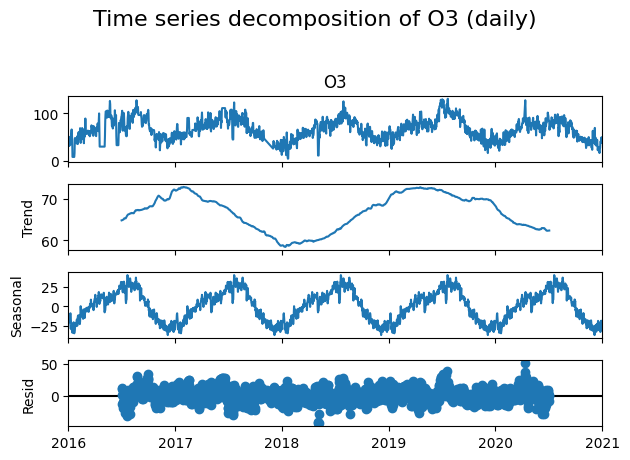

<Figure size 1200x800 with 0 Axes>

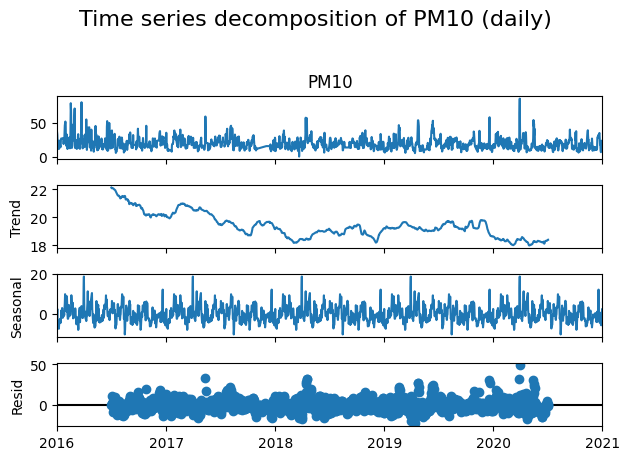

<Figure size 1200x800 with 0 Axes>

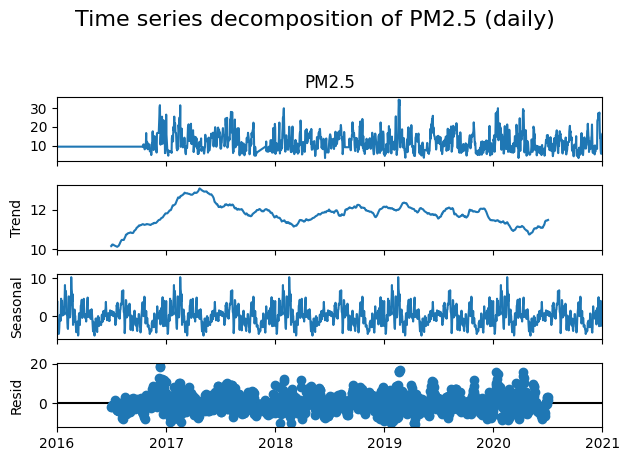

<Figure size 1200x800 with 0 Axes>

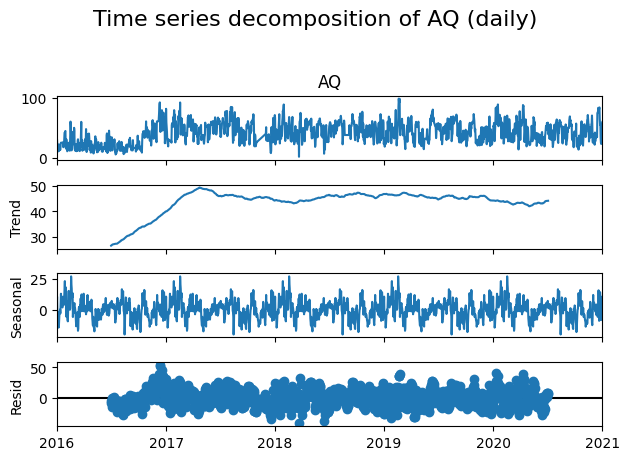

In [14]:
# TIME SERIES DECOMPOSITION
# decompose each pollutant's time series into trend, seasonality and residuals

# Parse DateTime flexibly — handles both with and without .000 microseconds
aq_df['DateTime'] = pd.to_datetime(aq_df['DateTime'], format='mixed', yearfirst=True, dayfirst=False)

# Optional: check how many rows failed to parse (should be 0 or very few)
print("Number of invalid dates:", aq_df['DateTime'].isna().sum())

# and parse the datetime format correctly (handles "YYYY-MM-DD HH:MM:SS.000")
aq_df['DateTime'] = pd.to_datetime(aq_df['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')

# Handle duplicate timestamps (your CSV has exact duplicates in 2020–2021)
# by averaging values per unique datetime
aq_df = aq_df.groupby('DateTime').mean().reset_index()

# Set Datetime as index (now a proper DatetimeIndex)
aq_df.set_index('DateTime', inplace=True)

daily_df = aq_df.resample('D').mean()

# Now run decomposition on the daily series
for pollutant in pollutants:
    # Interpolate missing values (linear is reasonable for air quality gaps)
    # and drop any remaining NaNs at the start/end so seasonal_decompose runs cleanly.
    series = daily_df[pollutant].interpolate(method='linear').dropna()

    if len(series) < 365 * 2:
        print(f"Skipping {pollutant} — not enough data after cleaning.")
        continue

    # Additive decomposition with yearly seasonality (period=365 on daily data)
    decomposition = seasonal_decompose(series, model='additive', period=365)

    # Plot decomposition components
    plt.figure(figsize=(12, 8))
    decomposition.plot()
    plt.suptitle(f'Time series decomposition of {pollutant} (daily)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # makes room for suptitle
    plt.show()

In [15]:
#MISSING VALUE IMPUTATION
#initialize imputer with median strategy
imputer = SimpleImputer(strategy = 'median')

#impute missing values in AQ columns
aq_df[pollutants] = imputer.fit_transform(aq_df[pollutants])

#verify no missing values remain
print(aq_df[pollutants].isnull().sum())

NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM2.5    0
AQ       0
dtype: int64


In [16]:
print(aq_df[pollutants].describe())
print("Skewness:\n", aq_df[pollutants].skew())

                 NO           NO2           NOX            O3          PM10  \
count  43123.000000  43123.000000  43123.000000  43123.000000  43123.000000   
mean       9.025258     24.015678     37.720272     66.187781     19.735969   
std       12.202507     17.232022     33.036854     26.967878     10.345903   
min        0.000000      0.009734      0.162730      0.000000      0.000000   
25%        2.494350     11.238211     16.304177     48.255769     13.600000   
50%        5.768315     20.354716     29.671525     65.924178     17.799990   
75%       11.433210     32.395025     49.543638     84.235745     23.600000   
max      411.701412    178.542330    796.962688    170.492181    323.565002   

              PM2.5            AQ  
count  43123.000000  43123.000000  
mean      11.520766     41.705767  
std        4.773978     17.763800  
min        3.100000      0.000000  
25%        8.600000     28.333334  
50%        9.700000     40.833333  
75%       14.100000     55.416309  


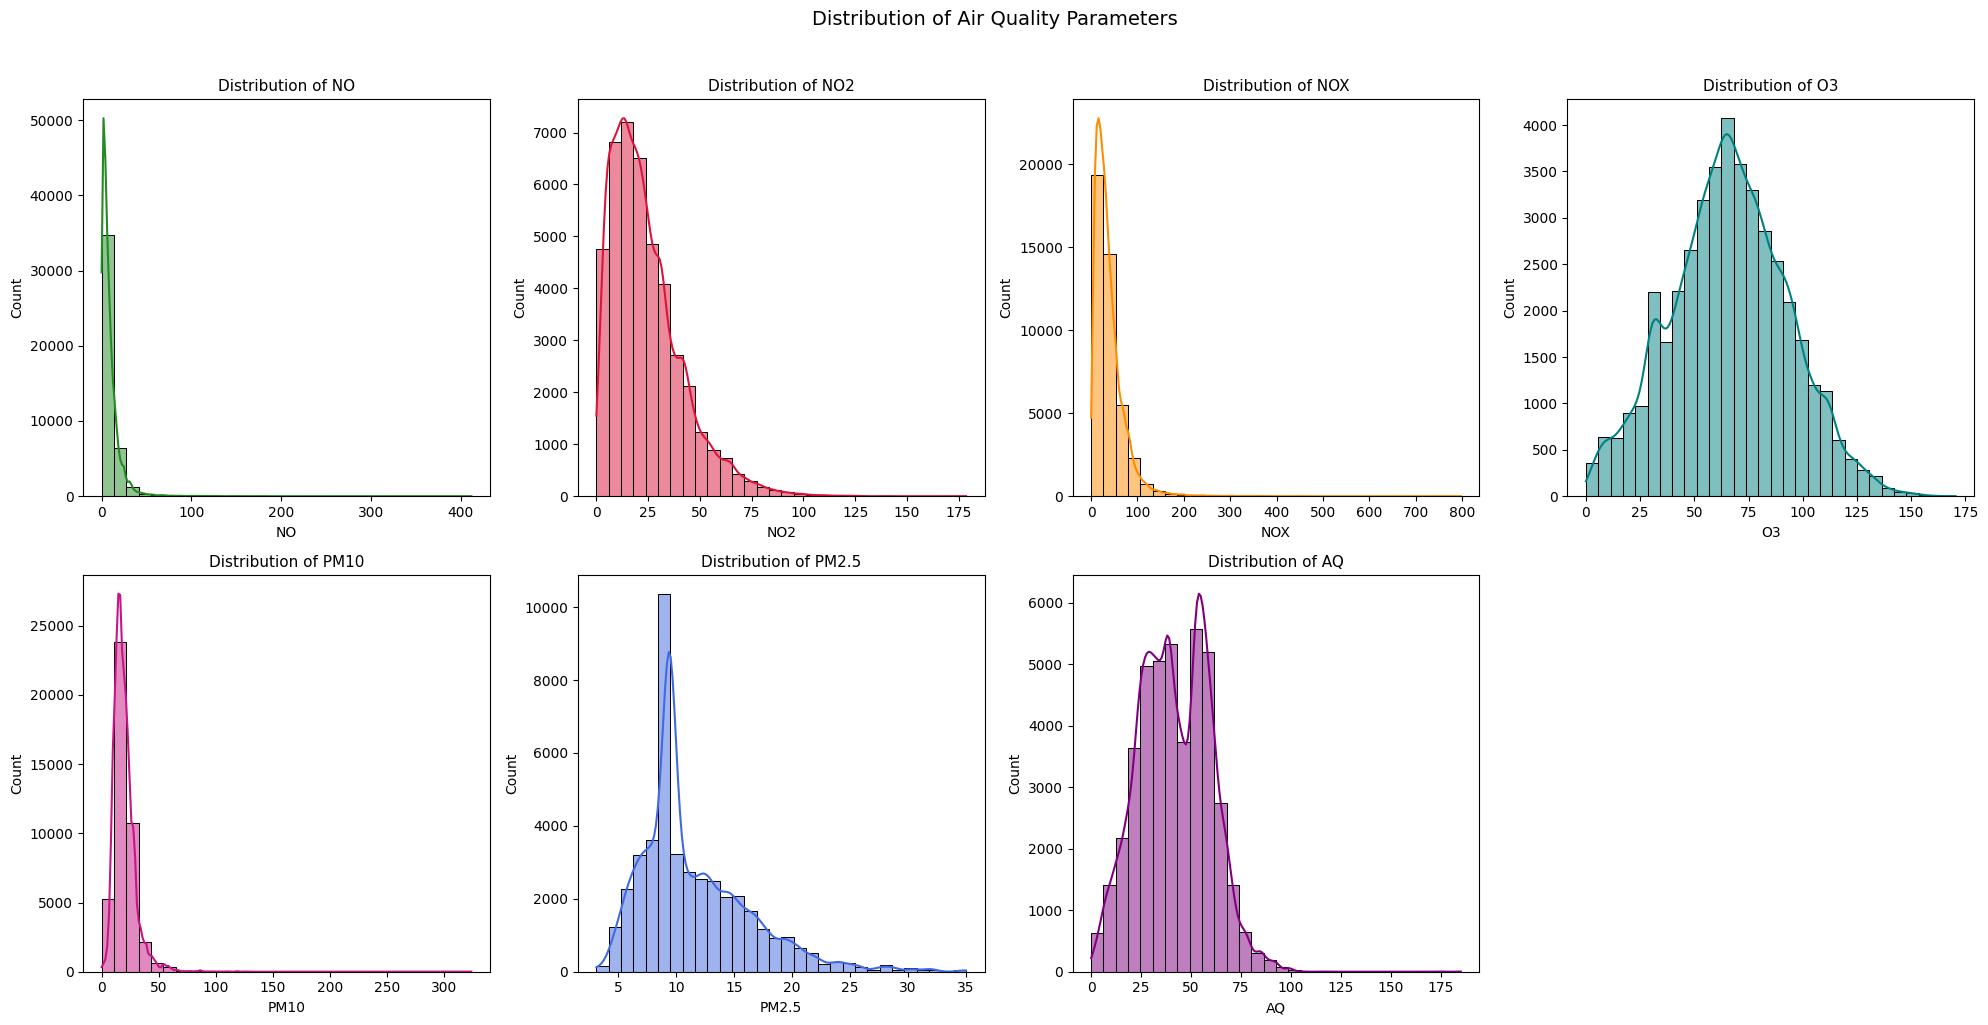

In [17]:
#DATA VISUALIZATION
colors = ['forestgreen', 'crimson', 'darkorange', 'teal', 'mediumvioletred', 'royalblue', 'purple']

plt.figure(figsize=(20, 10))

for i, (pollutant, color) in enumerate(zip(pollutants, colors)):
    plt.subplot(2, 4, i+1)

    # Plot the histogram + KDE
    sns.histplot( aq_df[pollutant], kde=True, color=color, bins=30 )

    # Get min and max for this specific pollutant
    data_min = aq_df[pollutant].min()
    data_max = aq_df[pollutant].max()

    # Optional: add a small margin so the plot doesn't cut off the edges
    margin = (data_max - data_min) * 0.05
    if margin == 0:  # avoid zero range
        margin = 1.0

    # Set x-axis limits
    plt.xlim(data_min - margin, data_max + margin)

    # Improve title (full name + units if you have them)
    plt.title(f'Distribution of {pollutant}', fontsize=11)

    # Optional: better x-label
    plt.xlabel(pollutant)
    plt.ylabel('Count')

# Final adjustments
plt.suptitle('Distribution of Air Quality Parameters', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

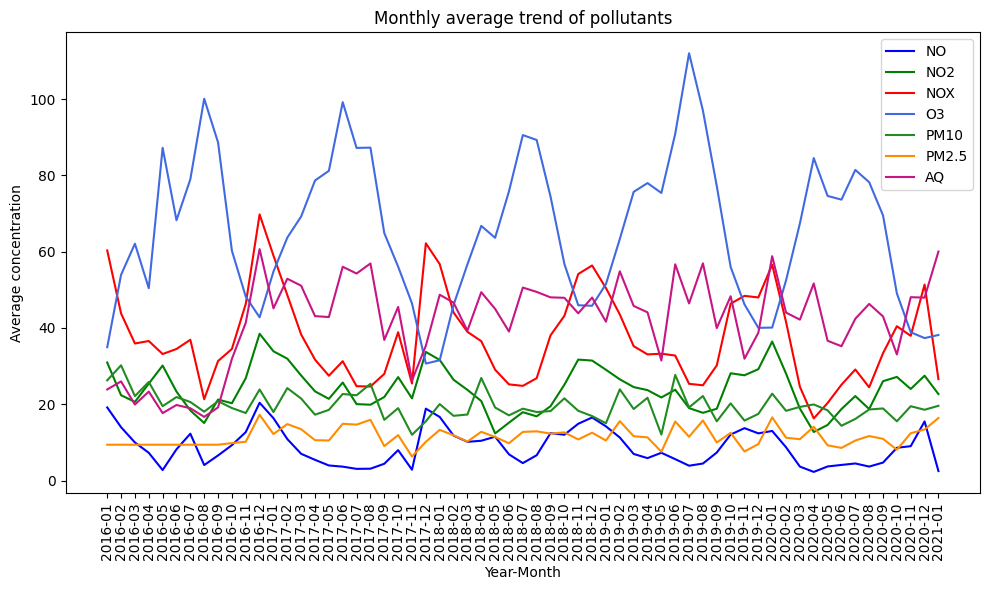

In [18]:
#monthly trend analysis
#create Year-Month period column for aggregation
aq_df['Year-Month'] = aq_df.index.to_period('M')

#calculate monthly averages for each pollutant
multi_pollutant_monthly_avg = aq_df.groupby('Year-Month')[pollutants].mean()

colors = ['blue', 'green', 'red', 'royalblue', 'forestgreen', 'darkorange', 'mediumvioletred']

#plot monthly trends
plt.figure(figsize = (10, 6))
for pollutant, color in zip(pollutants, colors):
    plt.plot(multi_pollutant_monthly_avg.index.astype(str), multi_pollutant_monthly_avg[pollutant], label = pollutant, color = color)
plt.title('Monthly average trend of pollutants')
plt.xlabel('Year-Month')
plt.ylabel('Average concentration')
plt.xticks(rotation = 90)
plt.legend()
plt.tight_layout()
plt.show()

count    43123.000000
mean         9.025258
std         12.202507
min          0.000000
25%          2.494350
50%          5.768315
75%         11.433210
max        411.701412
Name: NO, dtype: float64
DateTime
1     15.885197
2     11.339412
3      7.562010
4      6.263093
5      5.841099
6      5.688287
7      5.665250
8      4.394103
9      7.101260
10     9.986914
11    12.589762
12    16.737209
Name: NO, dtype: float64


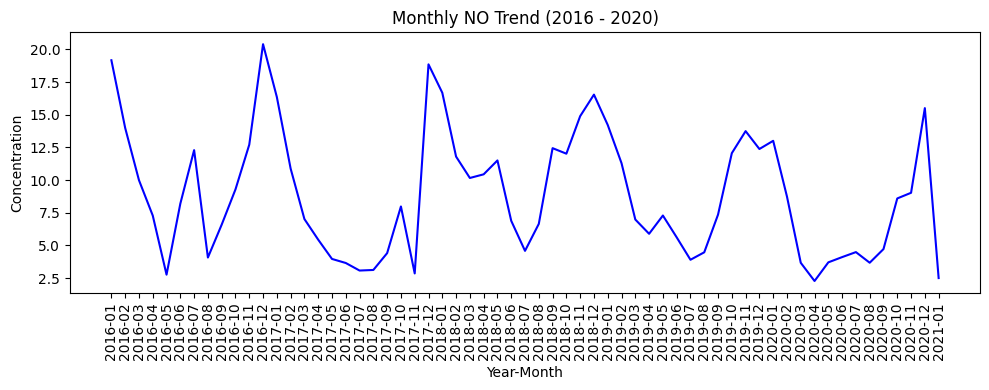

In [19]:
print(aq_df['NO'].describe()) #basic statistics
print(aq_df['NO'].groupby(aq_df.index.month).mean()) #monthly averages

plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['NO'],
         color = colors[0], label = 'NO')
plt.title('Monthly NO Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

count    43123.000000
mean        24.015678
std         17.232022
min          0.009734
25%         11.238211
50%         20.354716
75%         32.395025
max        178.542330
Name: NO2, dtype: float64
DateTime
1     32.386741
2     27.042359
3     23.066115
4     21.223376
5     20.063685
6     21.357052
7     19.502534
8     17.666087
9     21.505568
10    25.565832
11    27.538299
12    32.075435
Name: NO2, dtype: float64


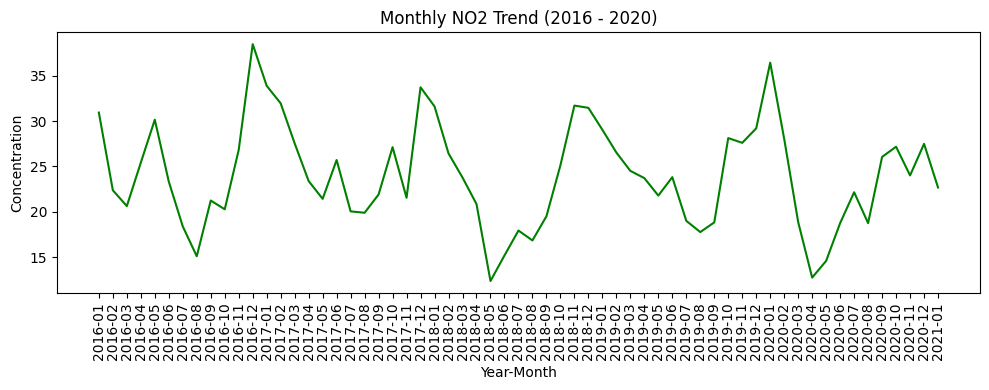

In [20]:

print(aq_df['NO2'].describe()) #basic statistics
print(aq_df['NO2'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['NO2'],
         color = colors[1], label = 'NO2')
plt.title('Monthly NO2 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()


count    43123.000000
mean        37.720272
std         33.036854
min          0.162730
25%         16.304177
50%         29.671525
75%         49.543638
max        796.962688
Name: NOX, dtype: float64
DateTime
1     56.617716
2     44.306861
3     34.610479
4     30.841689
5     28.665180
6     29.783135
7     28.193915
8     24.452729
9     32.189201
10    40.684004
11    46.702316
12    57.548631
Name: NOX, dtype: float64


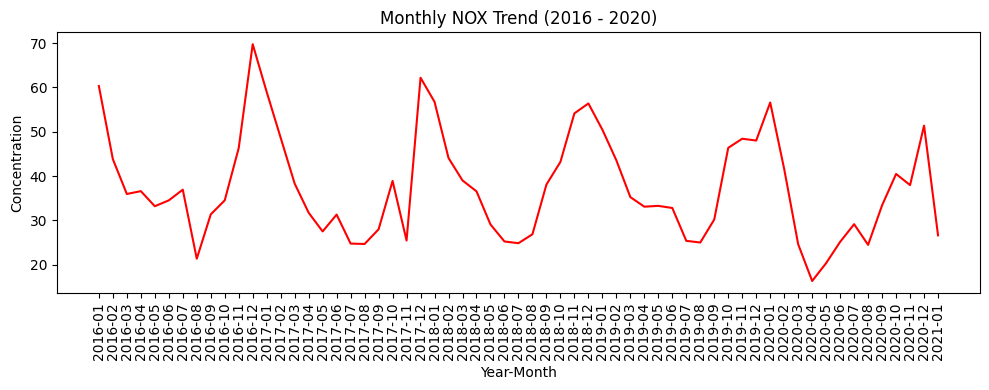

In [21]:
print(aq_df['NOX'].describe()) #basic statistics
print(aq_df['NOX'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['NOX'],
         color = colors[2], label = 'NOX')
plt.title('Monthly NOX Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

count    43123.000000
mean        66.187781
std         26.967878
min          0.000000
25%         48.255769
50%         65.924178
75%         84.235745
max        170.492181
Name: O3, dtype: float64
DateTime
1     42.583064
2     55.860629
3     66.220373
4     71.678509
5     76.420216
6     81.564930
7     90.045034
8     90.374688
9     74.939167
10    55.640762
11    44.813421
12    39.342222
Name: O3, dtype: float64


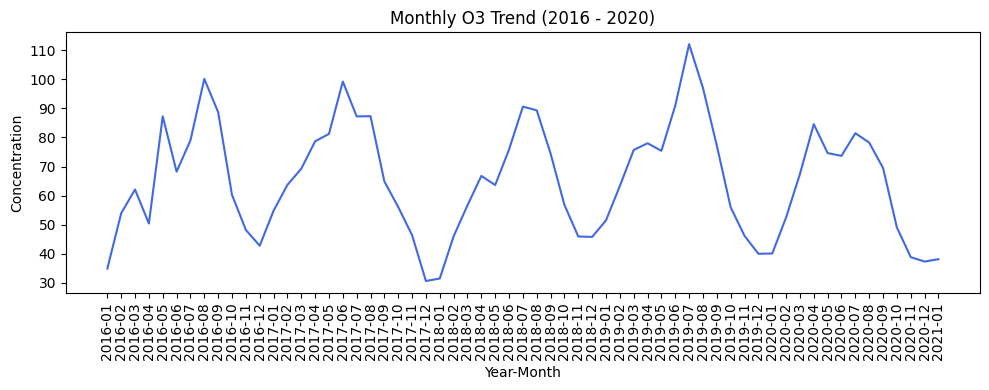

In [22]:
print(aq_df['O3'].describe()) #basic statistics
print(aq_df['O3'].groupby(aq_df.index.month).mean()) #monthly averages

plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['O3'],
         color = colors[3], label = 'O3')
plt.title('Monthly O3 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

count    43123.000000
mean        19.735969
std         10.345903
min          0.000000
25%         13.600000
50%         17.799990
75%         23.600000
max        323.565002
Name: PM10, dtype: float64
DateTime
1     20.421173
2     22.752128
3     19.808096
4     22.338641
5     17.533981
6     20.752630
7     19.430864
8     20.440726
9     17.877419
10    19.070211
11    17.803366
12    18.476875
Name: PM10, dtype: float64


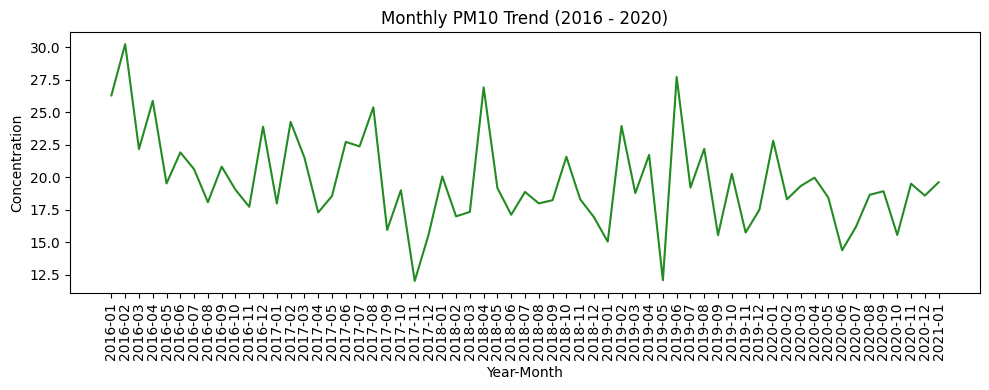

In [23]:
print(aq_df['PM10'].describe()) #basic statistics
print(aq_df['PM10'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['PM10'],
         color = colors[4], label = 'PM10')
plt.title('Monthly PM10 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()


count    43123.000000
mean        11.520766
std          4.773978
min          3.100000
25%          8.600000
50%          9.700000
75%         14.100000
max         35.000000
Name: PM2.5, dtype: float64
DateTime
1     12.392247
2     12.548620
3     11.113763
4     11.645333
5      9.624435
6     11.625389
7     11.762097
8     13.136021
9     10.336555
10    10.996989
11    10.248768
12    12.588948
Name: PM2.5, dtype: float64


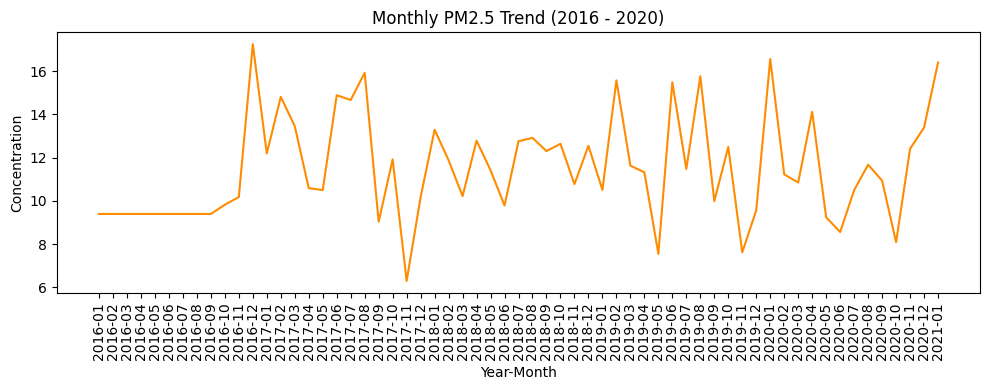

In [24]:
print(aq_df['PM2.5'].describe()) #basic statistics
print(aq_df['PM2.5'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['PM2.5'],
         color = colors[5], label = 'PM2.5')
plt.title('Monthly PM2.5 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()



count    43123.000000
mean        41.705767
std         17.763800
min          0.000000
25%         28.333334
50%         40.833333
75%         55.416309
max        184.936213
Name: AQ, dtype: float64
DateTime
1     43.651305
2     44.752031
3     39.654957
4     42.320692
5     34.739854
6     41.370968
7     42.538734
8     45.266020
9     37.414294
10    41.346636
11    41.308038
12    46.145878
Name: AQ, dtype: float64


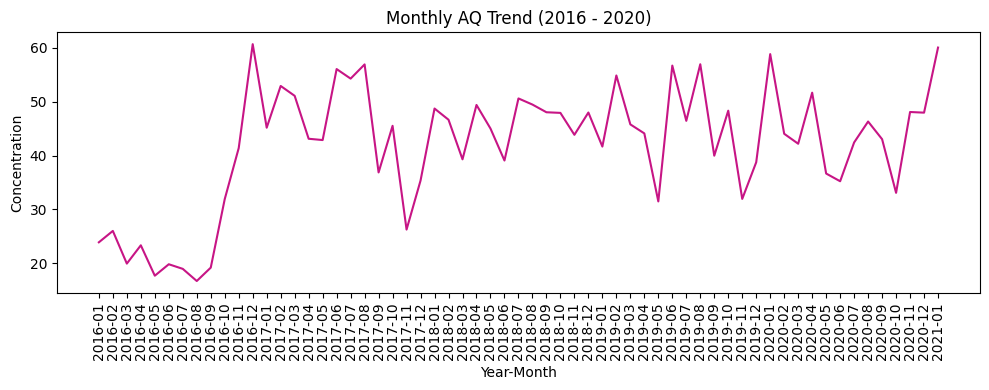

In [25]:
print(aq_df['AQ'].describe()) #basic statistics
print(aq_df['AQ'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['AQ'],
         color = colors[6], label = 'AQ')
plt.title('Monthly AQ Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

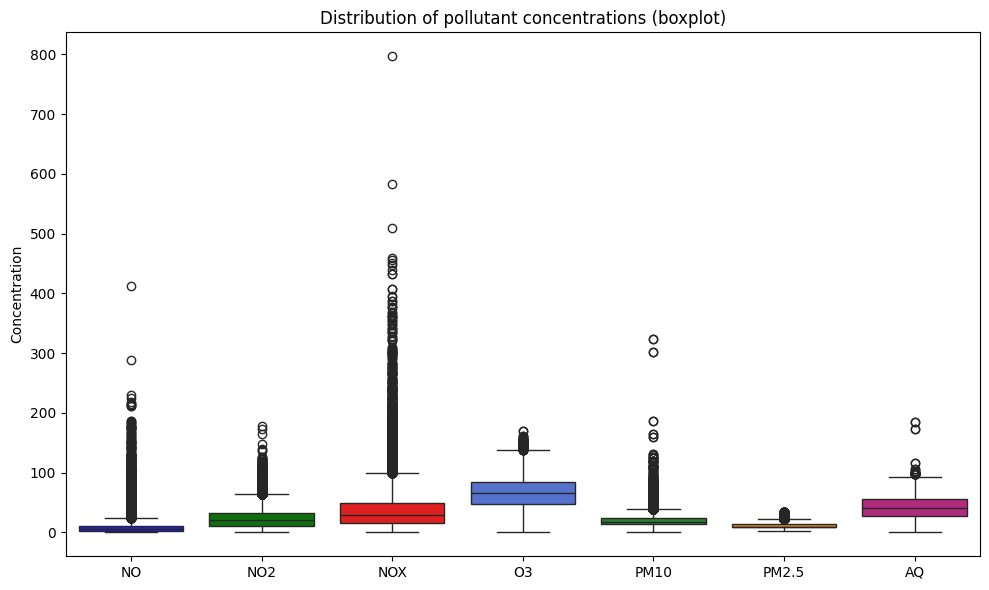

In [26]:
#boxplot visualization
plt.figure(figsize = (10, 6))
sns.boxplot(data = aq_df[pollutants], palette = colors)
plt.title('Distribution of pollutant concentrations (boxplot)')
plt.ylabel('Concentration')
plt.tight_layout()
plt.show()

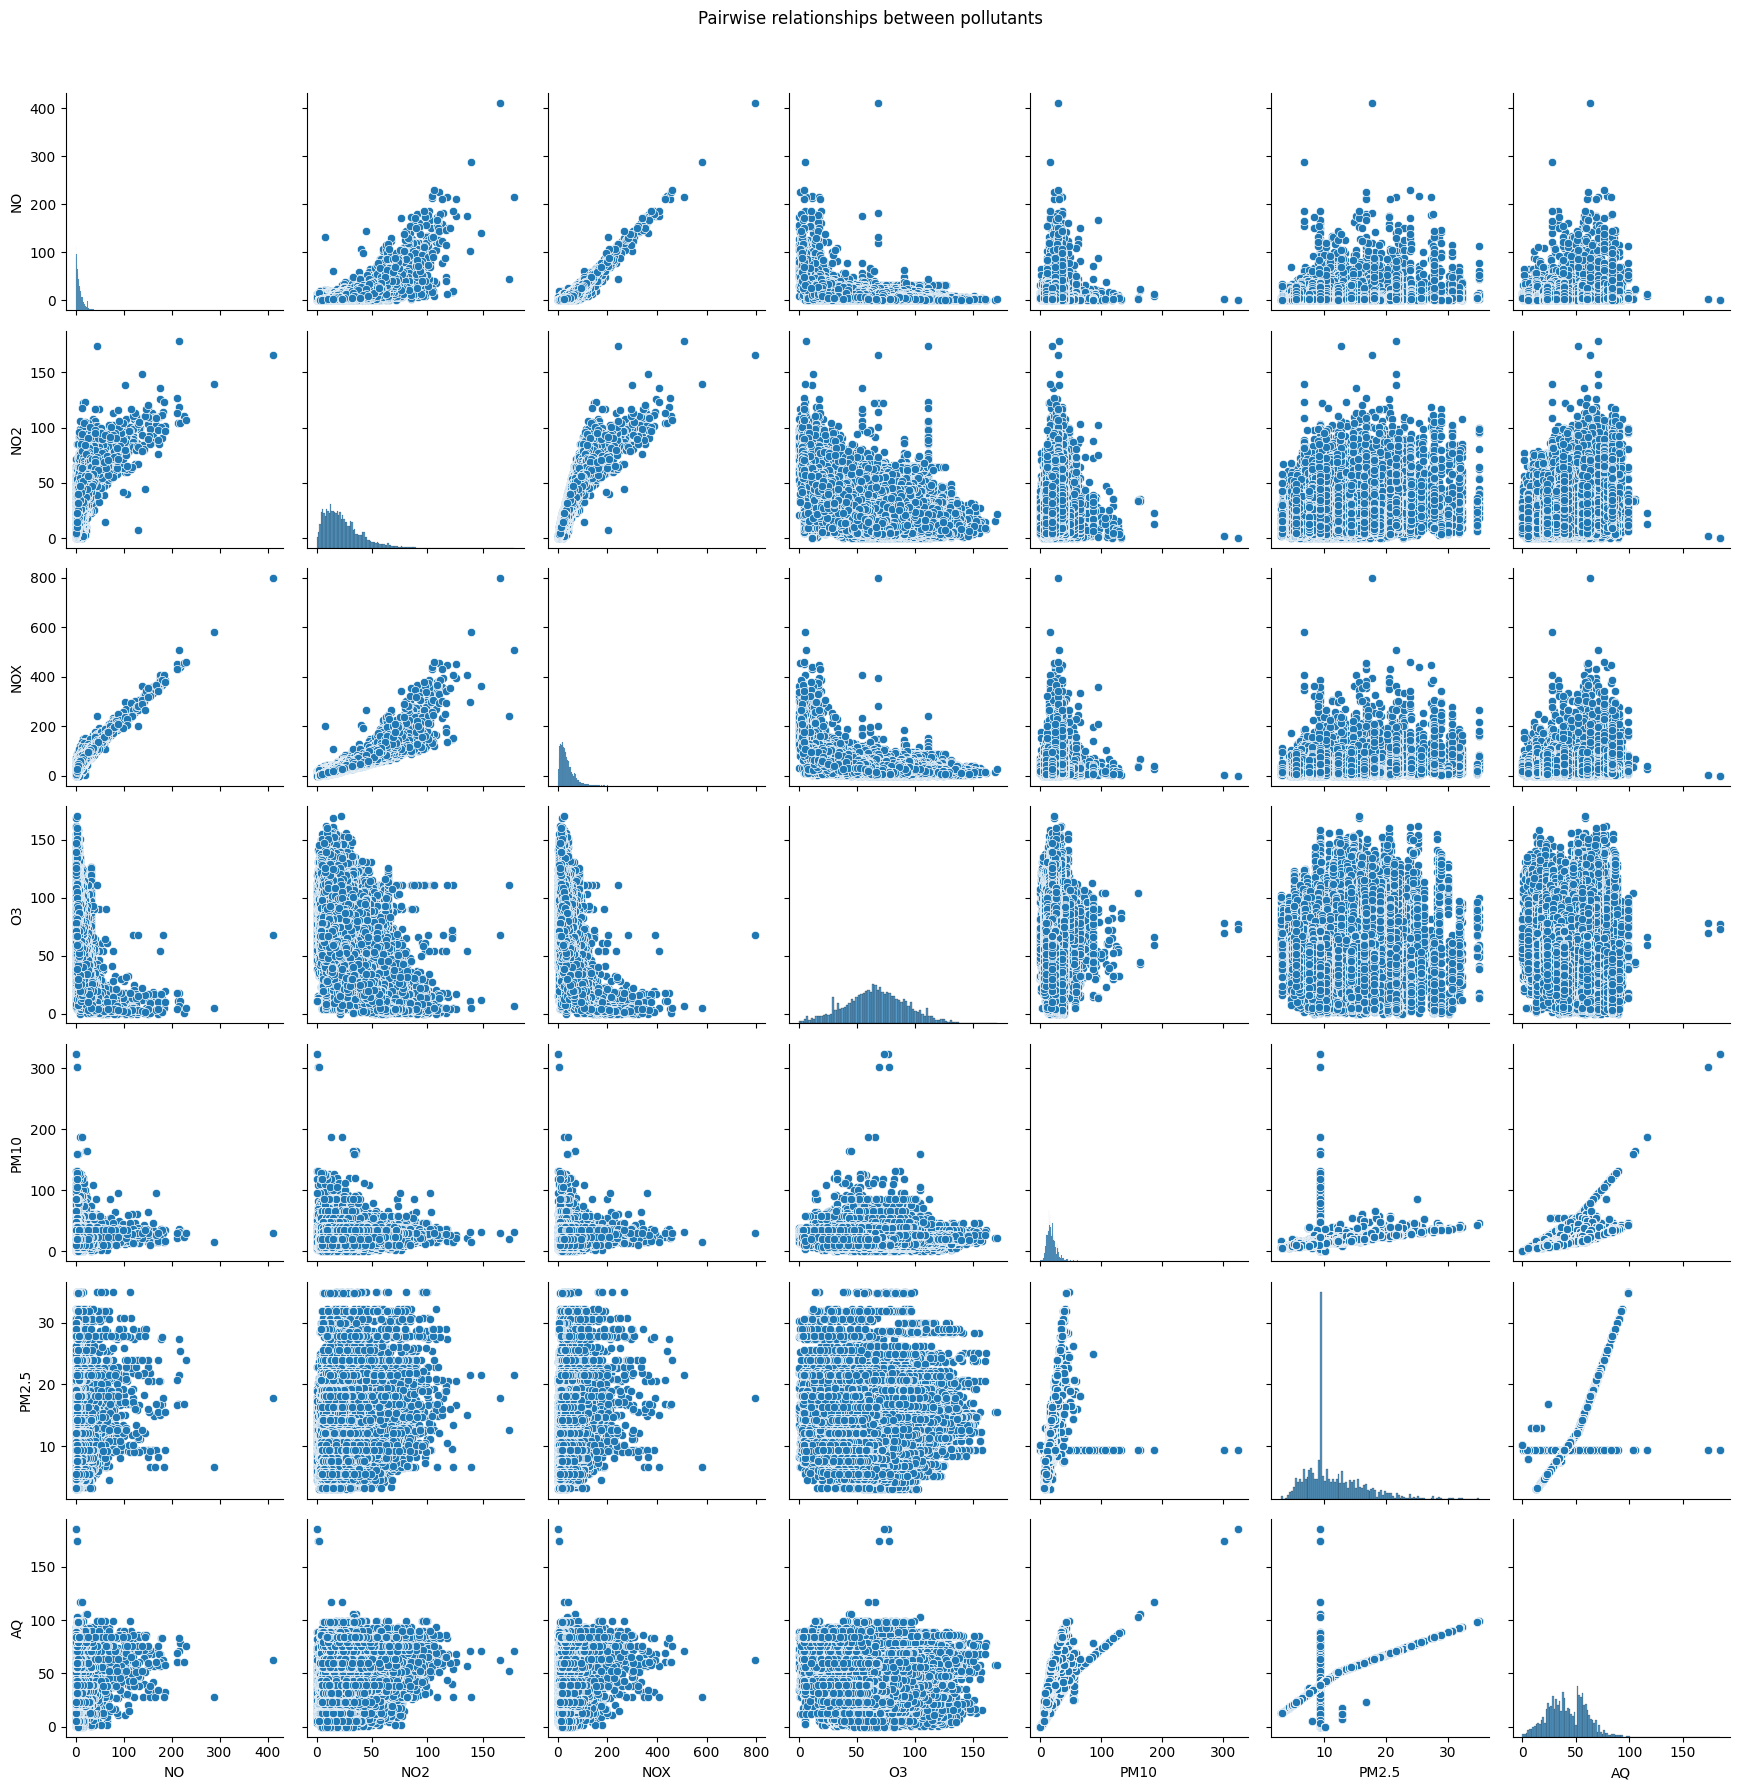

In [27]:
#pairwise relationships (pairplot)
sns.pairplot(aq_df[pollutants])
plt.suptitle('Pairwise relationships between pollutants', y = 1.02)
plt.tight_layout()
plt.show()

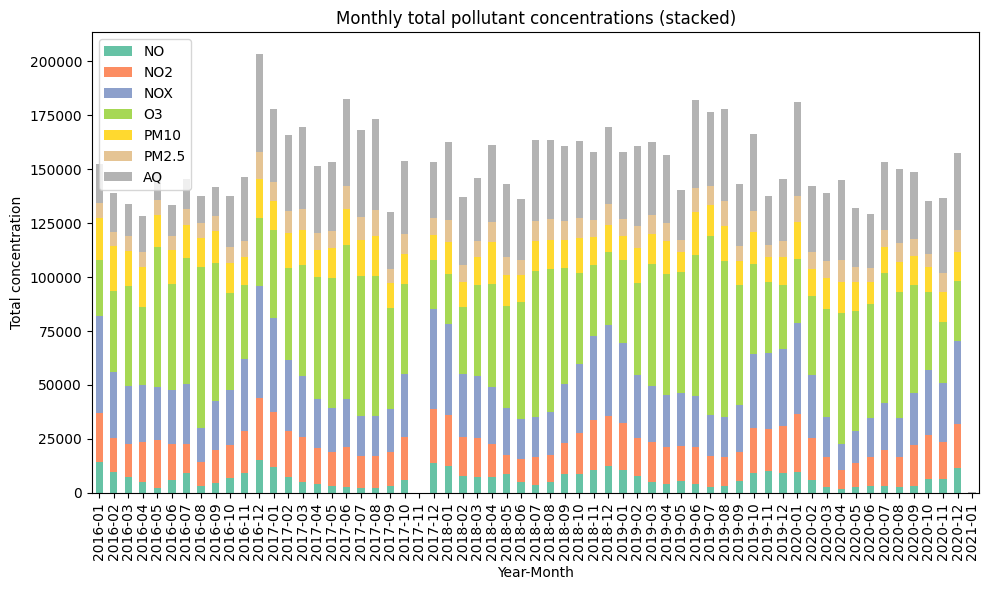

In [28]:
#stacked monthly totals
pollution_monthly_sum = aq_df.groupby('Year-Month')[pollutants].sum()
pollution_monthly_sum.plot(kind = 'bar', stacked = True, figsize = (10, 6), colormap = 'Set2')
plt.title('Monthly total pollutant concentrations (stacked)')
plt.xlabel('Year-Month')
plt.ylabel('Total concentration')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

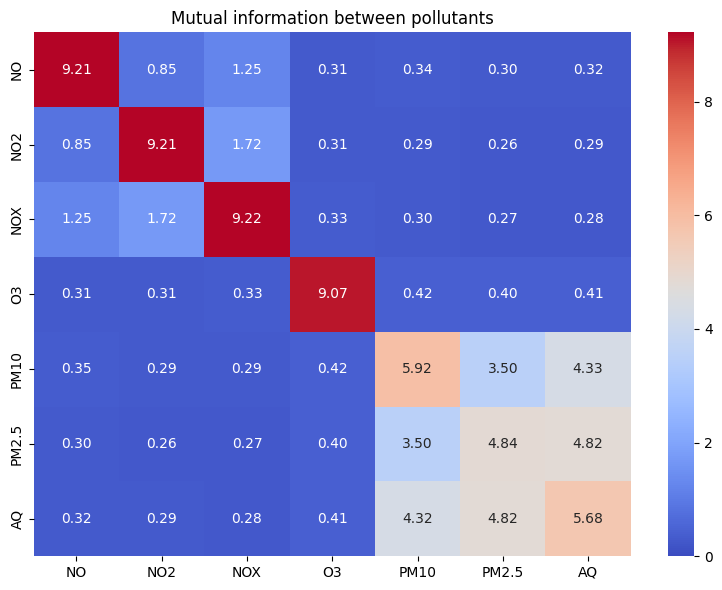

In [29]:
#MUTUAL INFORMATION ANALYSIS
#prepare feature matrix
X = aq_df[pollutants]

#calculate mutual information between all pollutants
mutual_info_all = {}
for target in X.columns:
    mutual_info = mutual_info_regression(X, X[target])
    mutual_info_all[target] = mutual_info

#convert to DataFrame for visualization
mutual_info_df = pd.DataFrame(mutual_info_all, index = X.columns)

#plot mutual information heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(mutual_info_df, annot = True, cmap = 'coolwarm', fmt = '.2f', vmin = 0)
plt.title('Mutual information between pollutants')
plt.tight_layout()
plt.show()

PART 2: Model Development and Evaluation

This section focuses on building and evaluating predictive models for AQ levels based on other pollutant measurements (PM10, NO2, NH3, Toluene, Xylene). We will:

1. Prepare the data for modeling (train-test split)

2. Compare three regression approaches:

  - Ridge Regression (linear model with regularization)

  - Decision Tree (non-linear, interpretable)

  - Random Forest (ensemble method)

3. Perform model diagnostics and validation

4. Evaluate final performance metrics

Key techniques used:

  - Residual analysis

  - Validation curves

  - Feature importance

  - Learning curves

  - Out-of-Bag (OOB) scoring

In [30]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score

In [31]:
#DATA PREPARATION
#prepare feature matrix (other pollutants) and target (NO2)
X = aq_df[['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']].values
y = aq_df['AQ'].values

#split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
models = {
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(oob_score = True)
}

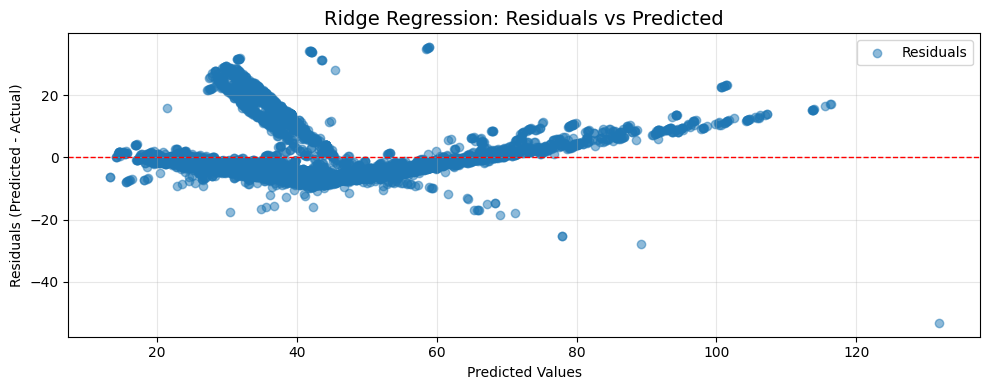

In [33]:
#RIDGE REGRESSION
#fit ridge model
models['Ridge Regression'].fit(X_train, y_train)
y_pred_lr = models['Ridge Regression'].predict(X_test)
residuals = y_pred_lr - np.array(y_test)

#plot residuals (predicted vs actual differences)
plt.figure(figsize = (10, 4))
plt.scatter(y_pred_lr, residuals, alpha=0.5, label = 'Residuals')
plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 1)
plt.title('Ridge Regression: Residuals vs Predicted', fontsize = 14)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - Actual)')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [48]:
#DECISION TREE
#validation curve to determine optimal tree depth
depths = range(1, 11)
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state = 42),
    X_train, y_train, param_name = "max_depth",
    param_range = depths,
    cv = 5,       #5-fold cross-validation
    scoring = "r2" #R-squared metric
)

In [49]:
#calculate the average of validation scores
mean_test_scores = np.mean(test_scores, axis = 1)

#find the max_depth with the highest R2 score
optimal_depth = depths[np.argmax(mean_test_scores)]
print(f"Optimal max_depth based on validation curve: {optimal_depth}")

for depth, score in zip(depths, mean_test_scores):
    print(f"Depth {depth}: R2 = {score:.3f}")

models['Decision Tree'] = DecisionTreeRegressor(max_depth = optimal_depth, random_state = 42)
models['Decision Tree'].fit(X_train, y_train)

Optimal max_depth based on validation curve: 10
Depth 1: R2 = 0.653
Depth 2: R2 = 0.779
Depth 3: R2 = 0.855
Depth 4: R2 = 0.892
Depth 5: R2 = 0.928
Depth 6: R2 = 0.965
Depth 7: R2 = 0.977
Depth 8: R2 = 0.983
Depth 9: R2 = 0.986
Depth 10: R2 = 0.989


DecisionTreeRegressor(max_depth=10, random_state=42)

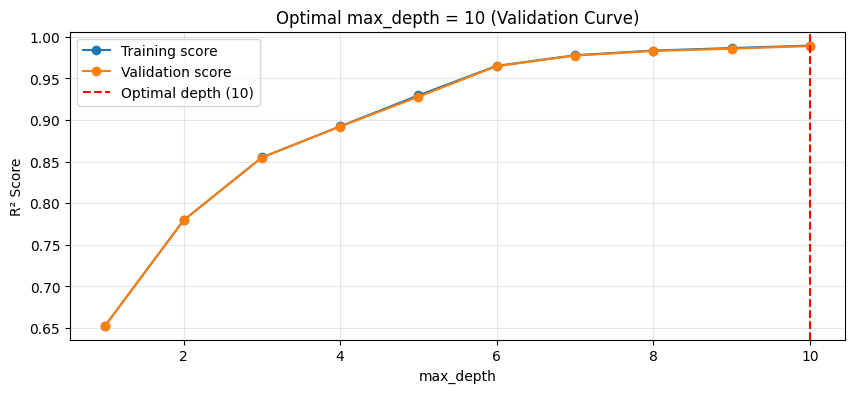

In [50]:
#plot
plt.figure(figsize = (10, 4))
plt.plot(depths, np.mean(train_scores, axis = 1), 'o-', label = 'Training score')
plt.plot(depths, mean_test_scores, 'o-', label = 'Validation score')
plt.axvline(x = optimal_depth, color = 'r', linestyle = '--', label = f'Optimal depth ({optimal_depth})')
plt.title(f'Optimal max_depth = {optimal_depth} (Validation Curve)')
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

NO: 0.02%
NO2: 0.06%
NOX: 0.01%
O3: 0.04%
PM10: 10.79%
PM2.5: 89.08%


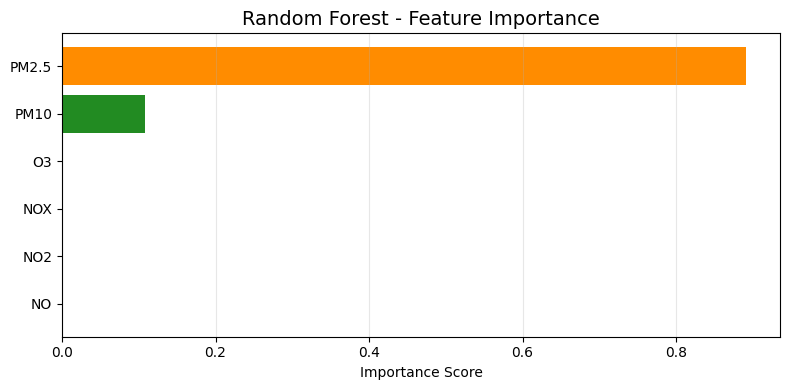

In [51]:
#RANDOM FOREST
#fit random forest model
models['Random Forest'] = RandomForestRegressor(n_estimators = 50, max_depth = 10, oob_score = True, bootstrap = True)
models['Random Forest'].fit(X_train, y_train)

importances = models['Random Forest'].feature_importances_
features = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']

for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.2%}")

#plot feature importance
plt.figure(figsize = (8, 4))
plt.barh(features, importances, color=colors[:len(features)])
plt.title('Random Forest - Feature Importance', fontsize = 14)
plt.xlabel('Importance Score')
plt.grid(axis = 'x', alpha = 0.3)
plt.tight_layout()
plt.show()

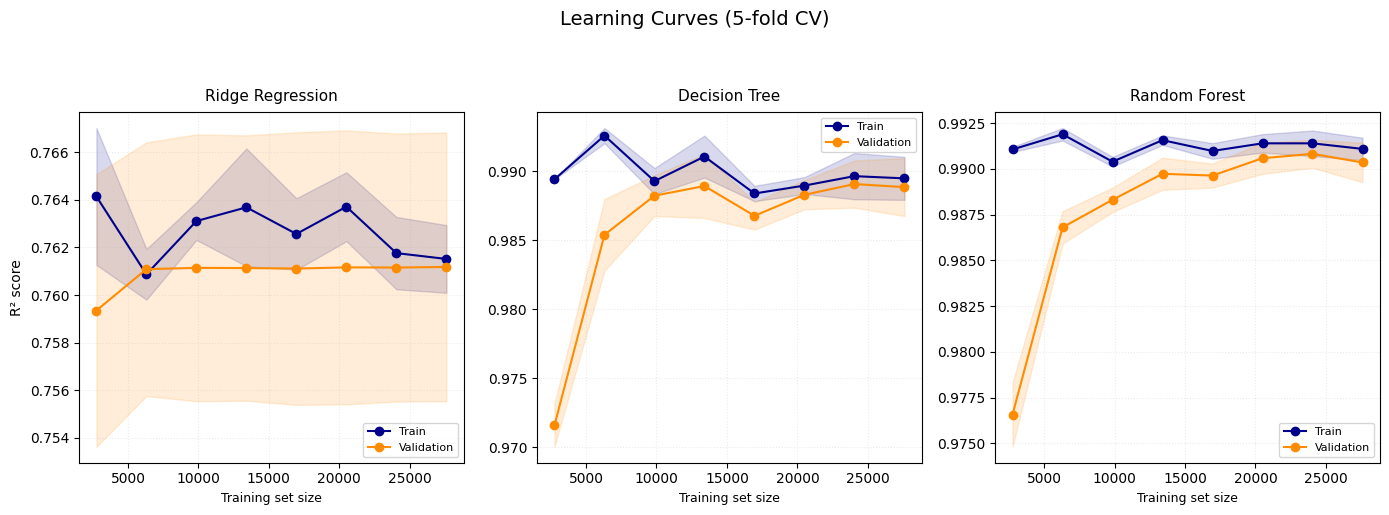

In [52]:
#LEARNING CURVES
plt.figure(figsize=(14, 5))  # slightly wider to fit 3 subplots comfortably

# You can adjust num_points based on dataset size & patience
num_points = 8                # good balance: 8–12 points
train_sizes = np.linspace(0.1, 1.0, num_points)   # starts earlier → better low-data behavior

for i, (name, model) in enumerate(models.items(), 1):
    # Generate learning curve data
    train_sizes_abs, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2',
        train_sizes=train_sizes,   # now using more points
        n_jobs=-1,                 # ← use all cores → much faster!
        random_state=42,           # for reproducibility (optional but good)
        verbose=0
    )

    # Average scores across folds
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    test_std   = np.std(test_scores, axis=1)

    # Plot
    plt.subplot(1, len(models), i)

    # Training curve with fill_between for variability
    plt.plot(train_sizes_abs, train_mean, 'o-', color='darkblue', label='Train')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                     alpha=0.15, color='darkblue')

    # Validation curve
    plt.plot(train_sizes_abs, test_mean, 'o-', color='darkorange', label='Validation')
    plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std,
                     alpha=0.15, color='darkorange')

    plt.title(name, fontsize=11, pad=8)
    plt.xlabel('Training set size', fontsize=9)
    if i == 1:
        plt.ylabel('R² score', fontsize=10)

    plt.legend(loc='best', fontsize=8)
    plt.grid(True, alpha=0.25, linestyle=':')


plt.suptitle('Learning Curves (5-fold CV)', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [53]:
dummy_models = {
    "Dummy (mean)":     DummyRegressor(strategy="mean"),
    "Dummy (median)":   DummyRegressor(strategy="median"),
    "Dummy (constant 100)": DummyRegressor(strategy="constant", constant=100)
}

In [54]:
# Fit dummies (they are very fast)
for name, model in dummy_models.items():
    model.fit(X_train, y_train)

all_models = {**dummy_models, **models}   # merge dictionaries


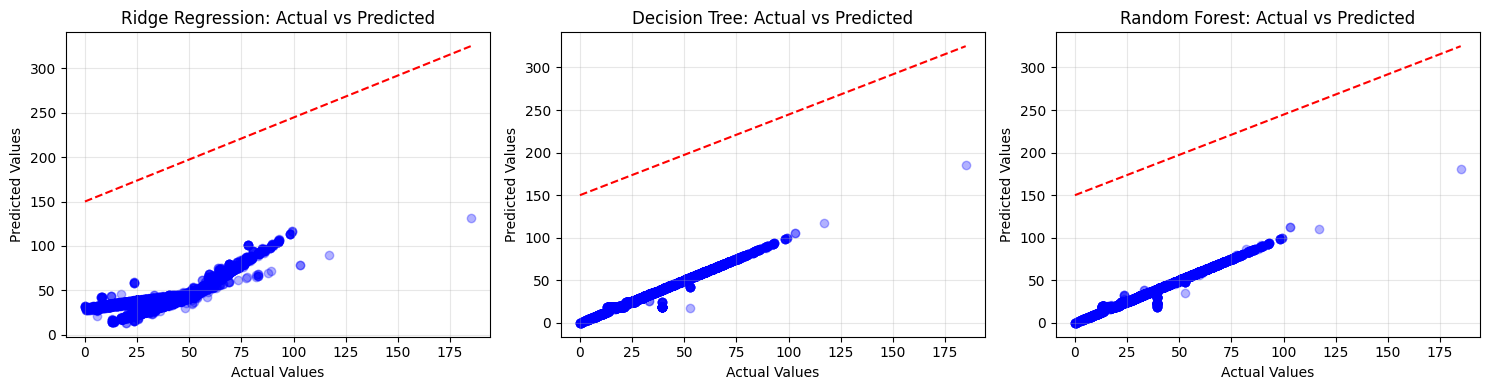

In [55]:
#ACTUAL VS PREDICTED

plt.figure(figsize = (15, 4))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha = 0.3, color = 'blue')
    plt.plot([y_test.min(), y_test.max()], [150, 325], 'r--') #perfect prediction line
    plt.title(f'{name}: Actual vs Predicted', fontsize = 12)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [56]:
results = []
for name, model in all_models.items():
    y_pred = model.predict(X_test)

    res = {
        'Model': name,
        'RMSE':  f"{np.sqrt(mean_squared_error(y_test, y_pred)):.3f}",
        'MAE':   f"{mean_absolute_error(y_test, y_pred):.2f}",
        'R²':    f"{r2_score(y_test, y_pred):.3f}",
    }

    # Only some ensemble models (RandomForest, ExtraTrees, etc.) have oob_score_
    if hasattr(model, 'oob_score_'):
        res['OOB Score'] = f"{model.oob_score_:.4f}"

    results.append(res)

print("\n=== PERFORMANCE SUMMARY (incl. dummy baselines) ===\n")
df_results = pd.DataFrame(results)

# Optional: sort by RMSE ascending (best models first)
df_results = df_results.sort_values("RMSE", key=lambda x: x.astype(float))

print(df_results.to_markdown(index=False, tablefmt="grid"))

# Quick sanity check message
best_real_rmse = df_results[~df_results['Model'].str.contains("Dummy")]['RMSE'].astype(float).min()
mean_dummy_rmse = df_results[df_results['Model'].str.contains("mean")]['RMSE'].astype(float).values[0]

print(f"\n→ Best real model RMSE: {best_real_rmse:.3f}")
print(f"→ Dummy (mean) RMSE:    {mean_dummy_rmse:.3f}")
if best_real_rmse >= mean_dummy_rmse * 0.97:
    print("⚠️  Warning: your best model is barely better than predicting the mean!")
else:
    print("→ Models are learning something useful (better than mean baseline).")


=== PERFORMANCE SUMMARY (incl. dummy baselines) ===

+----------------------+--------+-------+---------+-------------+
| Model                |   RMSE |   MAE |      R² |   OOB Score |
+======================+========+=======+=========+=============+
| Random Forest        |  1.7   |  0.36 |   0.991 |        0.99 |
+----------------------+--------+-------+---------+-------------+
| Decision Tree        |  1.874 |  0.37 |   0.989 |      nan    |
+----------------------+--------+-------+---------+-------------+
| Ridge Regression     |  8.693 |  6.25 |   0.764 |      nan    |
+----------------------+--------+-------+---------+-------------+
| Dummy (mean)         | 17.898 | 14.88 |  -0     |      nan    |
+----------------------+--------+-------+---------+-------------+
| Dummy (median)       | 17.916 | 14.86 |  -0.002 |      nan    |
+----------------------+--------+-------+---------+-------------+
| Dummy (constant 100) | 61.049 | 58.39 | -10.635 |      nan    |
+---------------------

PART 3: Time Series Prediction with LSTM

This section implements an LSTM neural network to predict NO2 levels using a time series approach. Key aspects:

1. Data Preparation:

  - Min-Max scaling of all features

  - Sequence creation with look-back window

  - Temporal train-test split (80-20)

2. Model Architecture:

  - Single LSTM layer (64 units)

  - Dropout for regularization

  - Early stopping and learning rate reduction

3. Evaluation:

  - Diagnostic plots (training/validation loss)

  - Time series predictions visualization

  - Standard metrics (RMSE, MAE, R2)

The implementation follows time series best practices:

  - Temporal splitting (no random shuffling)

  - Callbacks for efficient training

  - Proper inverse scaling of predictions

In [57]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [69]:
#DATA PREPARATION (vectorized)
#select features and scale to [0,1] range
features = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(aq_df[features].values)

In [70]:
#create sequences with look-back window
def create_sequences(data, look_back = 12):
    X = np.array([data[i:i+look_back] for i in range(len(data)-look_back)])
    y = data[look_back:, 0]  #NO2 Mean as target
    return X, y

X, y = create_sequences(data_scaled)
#temporal train-test split (80-20)
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

In [71]:
#MODEL ARCHITECTURE
model = Sequential([
    LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  #regularization
    Dense(1) #output layer
])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [72]:
#TRAINING WITH CALLBACKS
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-5, verbose=  1)
]

In [74]:
history = model.fit(x =X_train, y = y_train, validation_data = (X_test, y_test),
    epochs = 70, batch_size = 1024, callbacks = callbacks, verbose = 1, shuffle = False)

Epoch 1/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 5.3682e-04 - mae: 0.0125 - val_loss: 4.0269e-04 - val_mae: 0.0101 - learning_rate: 1.0000e-05
Epoch 2/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.3329e-04 - mae: 0.0125 - val_loss: 4.0273e-04 - val_mae: 0.0101 - learning_rate: 1.0000e-05
Epoch 3/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.2774e-04 - mae: 0.0124 - val_loss: 4.0218e-04 - val_mae: 0.0101 - learning_rate: 1.0000e-05
Epoch 4/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.2955e-04 - mae: 0.0125 - val_loss: 4.0208e-04 - val_mae: 0.0101 - learning_rate: 1.0000e-05
Epoch 5/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.3051e-04 - mae: 0.0124 - val_loss: 4.0234e-04 - val_mae: 0.0101 - learning_rate: 1.0000e-05
Epoch 6/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 5.2353e-04 - mae: 0.0123 - val_loss: 4.0240e-04 - val_mae: 0.0101 - learning_rate: 1.0000e-05
Epoch 7/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.2226e-04 - mae: 0.012

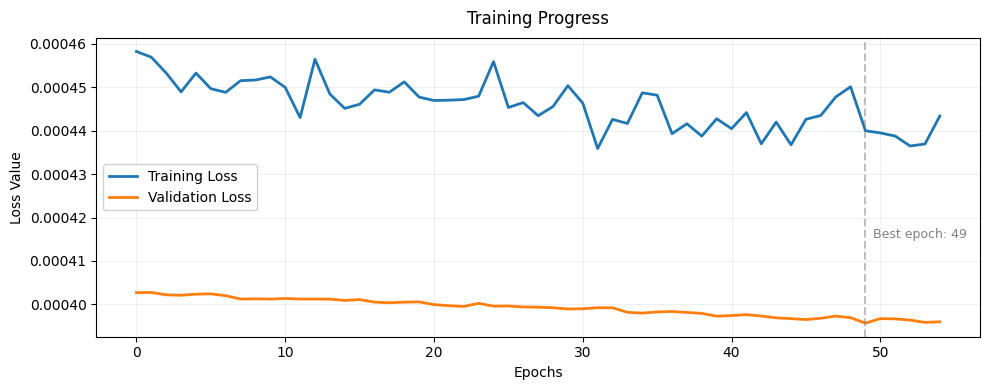

In [75]:
#TRAINING DIAGNOSTICS
plt.figure(figsize=(10, 4))

plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training Progress', fontsize=12, pad=10)
plt.ylabel('Loss Value', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(alpha=0.2)

#mark best epoch if early stopping occurred
if 'val_loss' in history.history and len(history.history['val_loss']) < history.params['epochs']:
    best_epoch = np.argmin(history.history['val_loss'])
    plt.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.5)
    plt.text(best_epoch+0.5, plt.ylim()[1]*0.9, f'Best epoch: {best_epoch}',
             fontsize=9, color='gray')
plt.tight_layout()
plt.show()

In [82]:
if X_train.ndim == 3:
    X_train_2d = X_train[:, -1, :]     # shape: (n_samples, n_features)
    X_test_2d  = X_test[:, -1, :]      # same for test

# Now scale
X_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train_2d)
X_test_scaled  = X_scaler.transform(X_test_2d)

print("Fixed shape:", X_train_scaled.shape)   # should be 2D

Fixed shape: (34488, 7)


In [84]:
n_features = scaler.n_features_in_
target_idx = 6

dummy_test = np.zeros((len(y_test), n_features))
dummy_test[:, target_idx] = y_test.flatten()
y_test_orig = scaler.inverse_transform(dummy_test)[:, target_idx]

dummy_pred = np.zeros((len(y_pred), n_features))
dummy_pred[:, target_idx] = y_pred.flatten()
y_pred_orig = scaler.inverse_transform(dummy_pred)[:, target_idx]

print("\nFirst few original-scale values:")
print("True :", y_test_orig[:5])
print("Pred :", y_pred_orig[:5])


First few original-scale values:
True : [10.88434942 12.04218371 12.85843059 12.69678404  5.39728458]
Pred : [ 6.95847646 10.0481905  10.56268964 10.26324415  9.76429649]


In [85]:
#calculate metrics
results = {
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
    'MAE': mean_absolute_error(y_test_orig, y_pred_orig),
    'R2': r2_score(y_test_orig, y_pred_orig)
}

print("\n=== LSTM RESULTS ===")
print(pd.DataFrame(results, index=['LSTM']).to_markdown(tablefmt="grid", floatfmt=".3f"))


=== LSTM RESULTS ===
+------+--------+-------+-------+
|      |   RMSE |   MAE |    R2 |
+======+========+=======+=======+
| LSTM |  3.679 | 1.830 | 0.526 |
+------+--------+-------+-------+


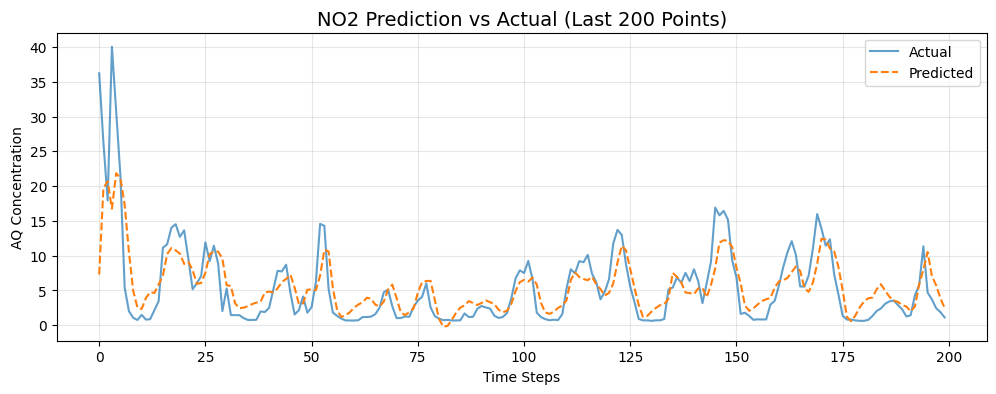

In [86]:
#PREDICTION VISUALIZATION (Last 200 points)
plt.figure(figsize=(12, 4))
plt.plot(y_test_orig[-200:], label='Actual', alpha=0.7)
plt.plot(y_pred_orig[-200:], label='Predicted', linestyle='--')
plt.title('NO2 Prediction vs Actual (Last 200 Points)', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('AQ Concentration')
plt.legend()
plt.grid(alpha=0.3)
plt.show()